# VAE提取星系图像n个特征

## 一、数据集准备（分为两个小关键点）
###   首先筛选合格数据（shape为[3，256，256]）
###   保存合格数据，方便后续读入

In [ ]:
import os
from astropy.io import fits
from tqdm import tqdm
b = 0
dir = '/data/GZ_Decals/'
files = os.listdir(dir)
train = open('/data/GZ_Decals/train_all.txt', 'w')#创建txt文件用于后续数据储存
for b in range(len(files)):
    #这里采用的是判断文件名的方式进行处理
    if 'merge' == files[b] or 'nomerge' == files[b]:
        ss = '/data/GZ_Decals/' + str(files[b]) + '/'
        pics = os.listdir(ss)
        for i in tqdm(range(len(pics))):
            if 'fits' in pics[i]:
                try:
                    name = str(dir) + str(files[b]) + '/' + pics[i] + '\n'
                    hdu = fits.open(name[:-1])
                    img = hdu[0].data
                    if len(img)==3 and len(img[0])==256:
                        train.write(name)
                    hdu.close()
                except:
                    continue
train.close()

## 二、将数据传入网络训练
###   2.1 训练模型中的数据
###   2.2 输出训练数据和VAE生成数据对比,保存网络模型和数据中提取的隐空间的变量


###   2.1 训练模型中的数据
####   加载相关环境
####   设置超参

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Nov 20 15:12:03 2021

@author: xuquanfeng
"""
from PIL import Image
import torch
from torchvision import datasets,transforms,utils,models
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import random
import os
import datetime
import torchvision
import torch.nn.functional as F
from astropy.io import fits
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch import optim
#设置随机种子

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = True
    os.environ['PYTHONHASHSEED'] = str(seed)
setup_seed(2000)
if not os.path.exists('./models'):
    os.mkdir('./models')

# Hyper parameters
num_epochs = 100   #循环次数
batch_size = 512    #每次投喂数据量
learning_rate = 0.00001
#学习率
momentum = 0.9
num_var = 500
correct = 0
total = 0
correct1 = 0
total1 = 0
num_correct = 0
num_correct2 =0
train_loss11 = open('./train_process/train_'+str(num_var)+'.txt', 'w')

####   加载数据集，进行一些变换

In [3]:
class MyDataset(torch.utils.data.Dataset):  # 创建自己的类：MyDataset,这个类是继承的torch.utils.data.Dataset
    def __init__(self, datatxt, transform=None, target_transform=None):  # 初始化一些需要传入的参数
        super(MyDataset, self).__init__()
        fh = open(datatxt, 'r')  # 按照传入的路径和txt文本参数，打开这个文本，并读取内容
        imgs = []  # 创建一个名为img的空列表，一会儿用来装东西
        for line in fh:  # 按行循环txt文本中的内容
            line = line.rstrip()  # 删除 本行string 字符串末尾的指定字符，这个方法的详细介绍自己查询python
            # words = line.split()  # 通过指定分隔符对字符串进行切片，默认为所有的空字符，包括空格、换行、制表符等
            imgs.append((line))
            # 很显然，words[0]是图片信息，words[1]是lable
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):  # 这个方法是必须要有的，用于按照索引读取每个元素的具体内容
        fn = self.imgs[index]  # fn是图片path #fn和label分别获得imgs[index]也即是刚才每行中word[0]和word[1]的信息
        hdu = fits.open(fn)
        img = hdu[0].data
        img = np.array(img,dtype=np.float32)
        hdu.close()
        if self.transform is not None:
            img = self.transform(img)
            img = img.permute(1,0,2)
        lab = img.max()
        # img = img/lab
        return img, lab
    def __len__(self):  # 这个函数也必须要写，它返回的是数据集的长度，也就是多少张图片，要和loader的长度作区分
        return len(self.imgs)
root = '/data/GZ_Decals/'
train_data = MyDataset(datatxt=root + 'train1.txt', transform=transforms.ToTensor())

#然后就是调用DataLoader和刚刚创建的数据集，来创建dataloader，这里提一句，loader的长度是有多少个batch，所以和batch_size有关
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size = batch_size, shuffle=True,num_workers=20)

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

# Device configuration  判断能否使用cuda加速
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

PyTorch Version:  1.10.0+cu113
Torchvision Version:  0.11.1+cu113


####   用torch框架构建VAE网络，定义损失函数和优化器

In [4]:
class VAE(nn.Module):
    def __init__(self,num_var):
        super(VAE, self).__init__()
        modules = []
        hidden_dims = [32, 64, 128, 256, 512]
        in_channels = 3
        latent_dim = num_var
        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*64, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*64, latent_dim)
        
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 64)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, x):
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.FloatTensor(std.size()).normal_().to(device)
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(len(result), 512, 8, 8)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar
model = VAE(num_var)

print(model)

net = model.to(device)

# reconstruction_function = nn.BCEWithLogitsLoss(size_average=False)
reconstruction_function = nn.MSELoss(size_average=False)

def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequentia

/data/xqf/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


####   开始训练网络

In [ ]:
strattime = datetime.datetime.now()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        img, lab = data
        # img = img.view(img.size(0), 3,256,256)        
        # img = img.permute(0,2,1,3)
        img = Variable(img)
        img = img.to(device)
        lab = lab.to(device)
        optimizer.zero_grad()
        recon_img, mu, logvar = model(img)
        recon_img = recon_img.T*lab
        loss = loss_function(recon_img.T, img, mu, logvar)
        # bn_img = img.T/lab
        # bn_img = bn_img.T
        # recon_img, mu, logvar = model(bn_img)
        # loss = loss_function(recon_img, bn_img, mu, logvar)
        loss.backward()
        # train_loss += loss.data[0]
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            endtime = datetime.datetime.now()
            asd = str('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} time:{:.2f}s'.format(
                epoch,
                batch_idx * len(img),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(img),
                (endtime-strattime).seconds))
            print(asd)
            train_loss11.write(asd+'\n')
            # torch.save(model, './model/b_vae'+str(epoch)+'_'+str(batch_idx)+'.pth')
    if epoch == 0:
        best_loss = train_loss / len(train_loader.dataset)
    if epoch > 0 and best_loss > train_loss / len(train_loader.dataset):
        best_loss = train_loss / len(train_loader.dataset)
        asds = 'Save Best Model!'
        print(asds)
        train_loss11.write(asds+'\n')
        torch.save(model, './models/vae_'+str(num_var)+'_best.pth')
    asds = str('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))
    print(asds)
    train_loss11.write(asds+'\n')
if epoch == num_epochs-1:
    torch.save(model, './models/vae_'+str(num_var)+'.pth')

train_loss11.close()

###   2.2 加载2.1节中训练好的网络生成图片和隐空间的变量，输出训练数据和VAE生成数据对比

In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 22 20:18:19 2021

@author: xuquanfeng
"""

root = '/data/GZ_Decals/'
train_data = MyDataset(datatxt=root + 'train1.txt', transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size = batch_size,shuffle=False,num_workers=20)

# Device configuration  判断能否使用cuda加速
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

torch.cuda.empty_cache()
model = torch.load('./models/vae_'+str(num_var)+'.pth')   ###加载模型

print(model)

net = model.to(device)

reconstruction_function = nn.MSELoss(size_average=False)

strattime = datetime.datetime.now()
for epoch in range(1):
    model.eval()
    datt = np.array(range(num_var))
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        img, _ = data
        img = Variable(img)
        img = img.to(device)
        imgs, mu, logvar = model(img)
        break
    break

PyTorch Version:  1.10.0+cu113
Torchvision Version:  0.11.1+cu113
VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


####   将其结果可视化看看，与原图区别大不大。

Text(0.5, 0.98, 'hidden dim')

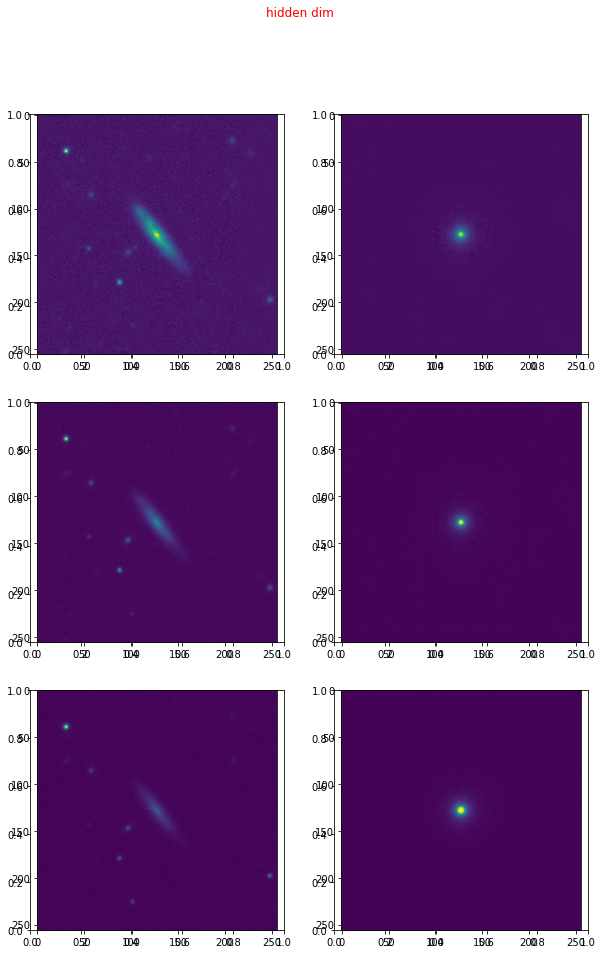

In [27]:
yunatu = img.cpu().numpy()
houtu = imgs.cpu().detach().numpy()
a=12

fig, axs = plt.subplots(3,2,figsize=(10, 15))
for i in range(3):
    
    ax = fig.add_subplot(3, 2, 1+2*i)
    plt.imshow(yunatu[a][i])    
#     plt.show()
#     plt.imshow(yunatu[a][:,i,:])
    ax = fig.add_subplot(3, 2, 2+2*i)
    plt.imshow(houtu[a][i])
fig.suptitle("hidden dim",color='r')

#### 查看各个隐变量的分布

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('result_'+str(num_var)+'.npy')##与前两格的保存结果名字得相同
np.save('resu_'+str(num_var)+'.npy',dat)##模型运算的结果，其中每一行的n个隐变量与train.txt文件中的每一行的文件名一一对应

for i in range(dat.shape[1]):
    dd = dat[:,i]
    me = np.mean(dd)
    var = np.var(dd)
    print(me,var)

dd = data.reshape(-1)
me = np.mean(dd)
var = np.var(dd)
print(me,var)

## 三、对比不同n隐变量数据
###   生成n个特征
###   对比多次训练的不同n的loss

上述二产生的为n=40时产生的模型，可设置num_var为不同值，而后根据不同num_var得出第100个epoch的loss值进行画图。

6
12
18
24
30
40
[6449.7907, 6373.2722, 6340.3771, 6315.2188, 6302.0307, 6287.1592]


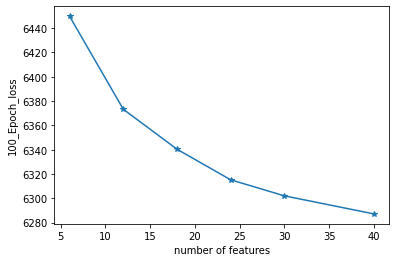

In [9]:
import numpy as np
import matplotlib.pyplot as plt

aa = [6,12,18,24,30,40]
bb = []
for i in aa:
    num = open('train_'+str(i)+'.txt','r')
#     print(i)
    line = []
    for l in num:
        line.append(l)
    linn = line[-1]
    lin = linn.split(":")
    bb.append(eval(lin[-1]))
print(bb)
# bb = [6449.7907,6373.2722,6340.3771,6315.2188,6302.0307,6287.1592]
plt.plot(aa,bb,'*-')
plt.xlabel('number of features')
plt.ylabel('100_Epoch_loss')
plt.show()

PyTorch Version:  1.10.0+cu113
Torchvision Version:  0.11.1+cu113


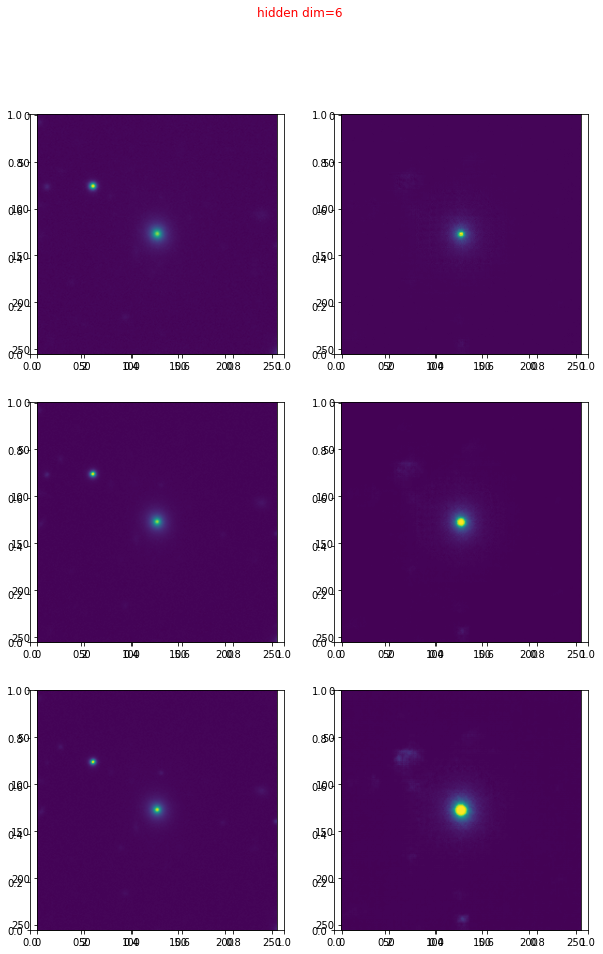

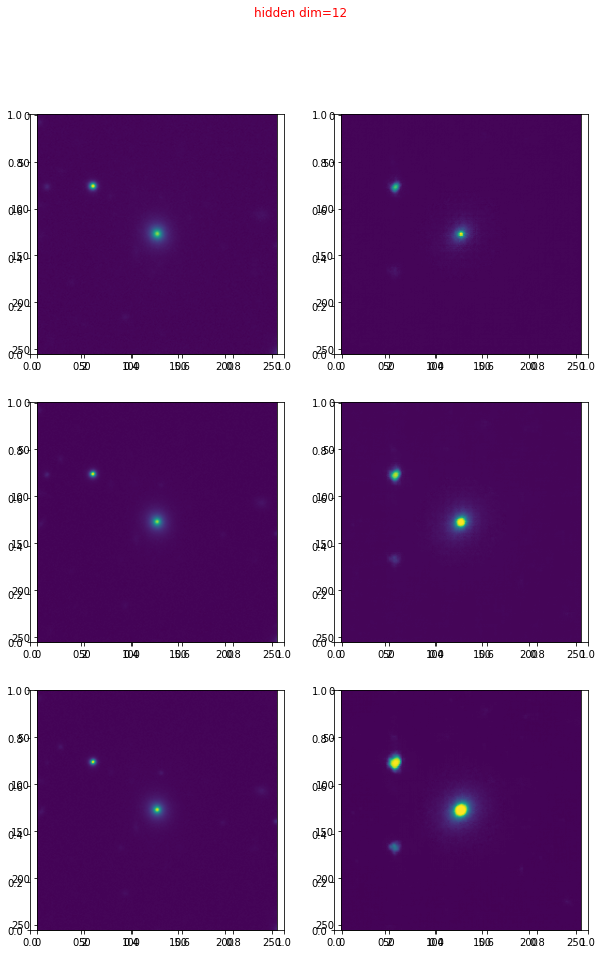

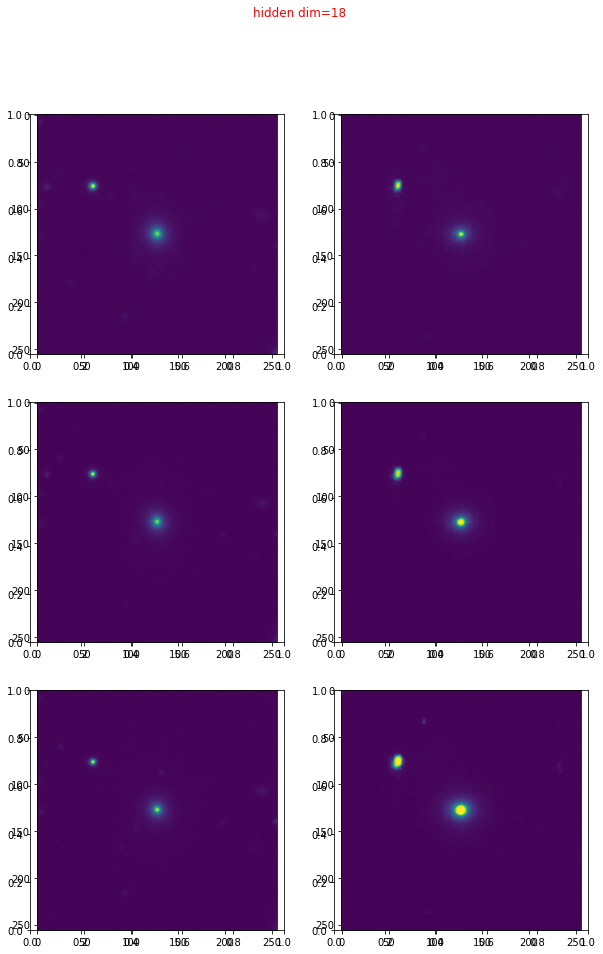

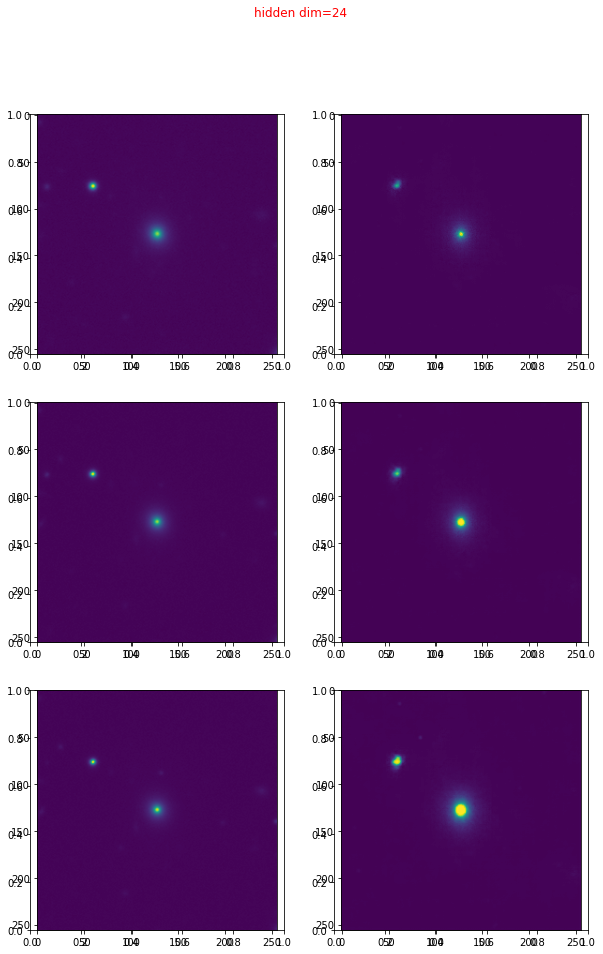

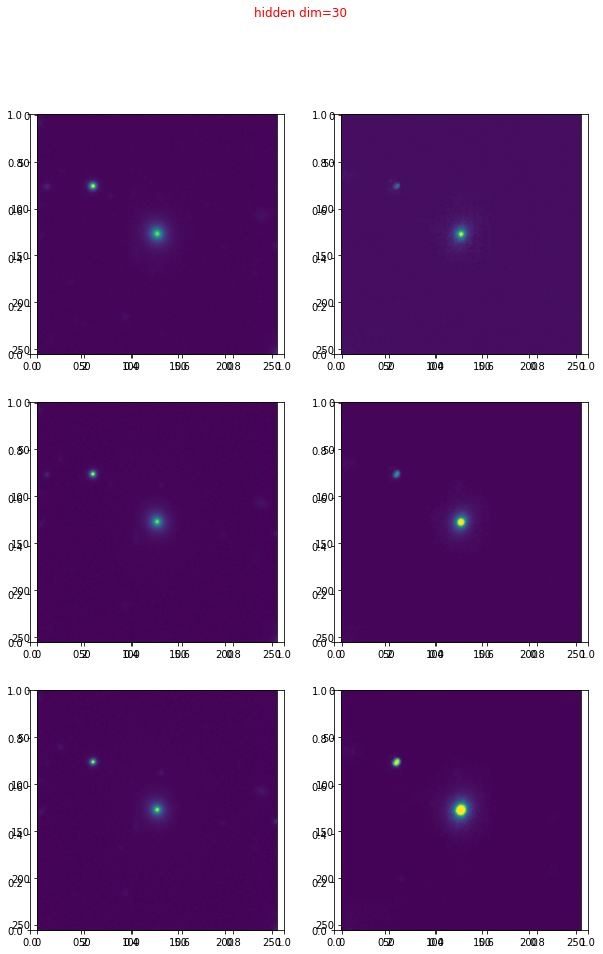

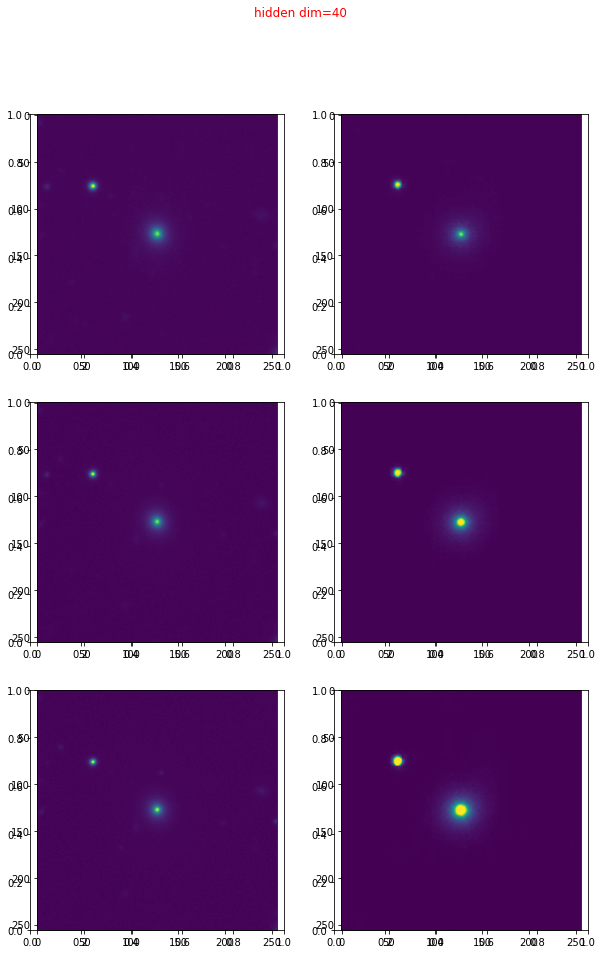

In [29]:
root = '/data/GZ_Decals/'
train_data = MyDataset(datatxt=root + 'train1.txt', transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size = batch_size,shuffle=False,num_workers=20)

# Device configuration  判断能否使用cuda加速
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

for num_var in aa:

    torch.cuda.empty_cache()
    model = torch.load('./models/vae99_'+str(num_var)+'.pth')   ###加载模型

#     print(model)

    net = model.to(device)

    for batch_idx, data in enumerate(train_loader):
        img, _ = data
        img = Variable(img)
        img = img.to(device)
        imgs, mu, logvar = model(img)
        break
    yunatu = img.cpu().numpy()
    houtu = imgs.cpu().detach().numpy()
    a=1
    fig, axs = plt.subplots(3,2,figsize=(10, 15))
    for i in range(3):
        ax = fig.add_subplot(3, 2, 1+2*i)
        plt.imshow(yunatu[a][i])
        ax = fig.add_subplot(3, 2, 2+2*i)
        plt.imshow(houtu[a][i])
    fig.suptitle("hidden dim="+str(num_var),color='r')